# Advanced Machine Learning
## Project 2: Deep Reinforcement Learning
## Group 4

Fatma Özel, nº 57037 <br>
Nuno Costa, nº 58635


## Introduction

In this project, we will train and compare three different reinforcement learning agents: Q-learning, Deep Q-network (DQN), and Soft Actor-Critic (SAC). We will use the MountainCar-v0 environment from Gymnasium.


## Setup and Imports

In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import gymnax
import jax
import time
from RLinJAX import *

In [2]:
def discretize_state(state, position_bins, velocity_bins): # comentário a explicar
    """Convert continuous state to discrete bins.
    Args:
        state (tuple): Continuous (position, velocity).
        position_bins (array): Bins for discretizing position.
        velocity_bins (array): Bins for discretizing velocity.

    Returns:
        tuple: Discrete (position index, velocity index).
    """
    position, velocity = state
    pos_idx = np.clip(np.digitize(position, bins=position_bins) - 1, 0, len(position_bins) - 1)
    vel_idx = np.clip(np.digitize(velocity, bins=velocity_bins) - 1, 0, len(velocity_bins) - 1)
    return int(pos_idx), int(vel_idx)

### Part 1: Train a Q-learning Agent
#### Environment Setup and Discretization

In [3]:
# Load MountainCar environment
env = gym.make('MountainCar-v0')

# Discretize position and velocity
position_bins = np.linspace(-1.2, 0.6, num=30)  # We tested for 5, 10, 20 and 30 and 30 was the best value
velocity_bins = np.linspace(-0.07, 0.07, num=30)  # We tested for 5, 10, 20 and 30 and 30 was the best value

#### Q-learning Algorithm Implementation

In [4]:
# Initialize Q-table
num_actions = env.action_space.n 

#create Q-table
q_table = {}
for position in range(len(position_bins)):
    for velocity in range(len(velocity_bins)):
        for action in range(num_actions):
            q_table[(position, velocity, action)] = 0.0  

# Epsilon-greedy policy
def epsilon_greedy(state, epsilon):
    """Choose an action using epsilon-greedy policy.""" # We changed a bit of the function to work we this envirment
    pos_idx, vel_idx = state
    if random.uniform(0, 1) < epsilon:
        action = random.choice(range(num_actions))
    else:
        action = np.argmax([q_table[(pos_idx, vel_idx, action)] for action in range(num_actions)])
    return action

#### Training the Q-learning Agent

In [ ]:
# Q-learning parameters
alpha = 0.1  # means the Q-values adjust slowly, balancing stability and adaptability
gamma = 0.99 # means the agent values future rewards almost as much as current rewards
epsilon = 1.0 #inicial value
epsilon_decay = 0.9992 # we tryed from 0.999 to 0.9999 and 0.9992 was the best value
min_epsilon = 0.01 # we tryed from 0.01 to 0.1 and 0.01 was the best value
num_episodes = 10000  # we tryed from 1000 to 10000 and 10000 and 10000 was the best value
num_steps = 200 # default

# Training loop
rewards = []
for i in range(num_episodes):
    s, _ = env.reset()
    s = discretize_state(s,  position_bins, velocity_bins) 
    total_reward = 0

    for t in range(num_steps):
        # Select action using epsilon-greedy policy
        a = epsilon_greedy(s, epsilon)

        # Take the action and observe the next state and reward
        s_, r, done, _, _ = env.step(a)
        s_ = discretize_state(s_,  position_bins, velocity_bins)

        # Update Q-value using Bellman equation
        best_next_action = np.argmax([q_table[(s_[0], s_[1], action)] for action in range(num_actions)])  
        q_table[(s[0], s[1], a)] += alpha * (r + gamma * q_table[(s_[0], s_[1], best_next_action)] - q_table[(s[0], s[1], a)])

        # Update state
        s = s_
        total_reward += r

        # Break if terminal state is reached
        if done:
            break

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    rewards.append(total_reward)
    if (i + 1) % 200 == 0:
        print(f"Episode {i + 1}/{num_episodes}: Total Reward = {total_reward}, Epsilon = {epsilon:.3f}")

env.close()

Episode 200/10000: Total Reward = -200.0, Epsilon = 0.852
Episode 400/10000: Total Reward = -200.0, Epsilon = 0.726
Episode 600/10000: Total Reward = -200.0, Epsilon = 0.619
Episode 800/10000: Total Reward = -200.0, Epsilon = 0.527
Episode 1000/10000: Total Reward = -195.0, Epsilon = 0.449
Episode 1200/10000: Total Reward = -171.0, Epsilon = 0.383
Episode 1400/10000: Total Reward = -195.0, Epsilon = 0.326
Episode 1600/10000: Total Reward = -155.0, Epsilon = 0.278
Episode 1800/10000: Total Reward = -154.0, Epsilon = 0.237
Episode 2000/10000: Total Reward = -151.0, Epsilon = 0.202
Episode 2200/10000: Total Reward = -118.0, Epsilon = 0.172
Episode 2400/10000: Total Reward = -147.0, Epsilon = 0.146
Episode 2600/10000: Total Reward = -148.0, Epsilon = 0.125
Episode 2800/10000: Total Reward = -150.0, Epsilon = 0.106
Episode 3000/10000: Total Reward = -145.0, Epsilon = 0.091
Episode 3200/10000: Total Reward = -152.0, Epsilon = 0.077
Episode 3400/10000: Total Reward = -155.0, Epsilon = 0.066
E

#### Visualization

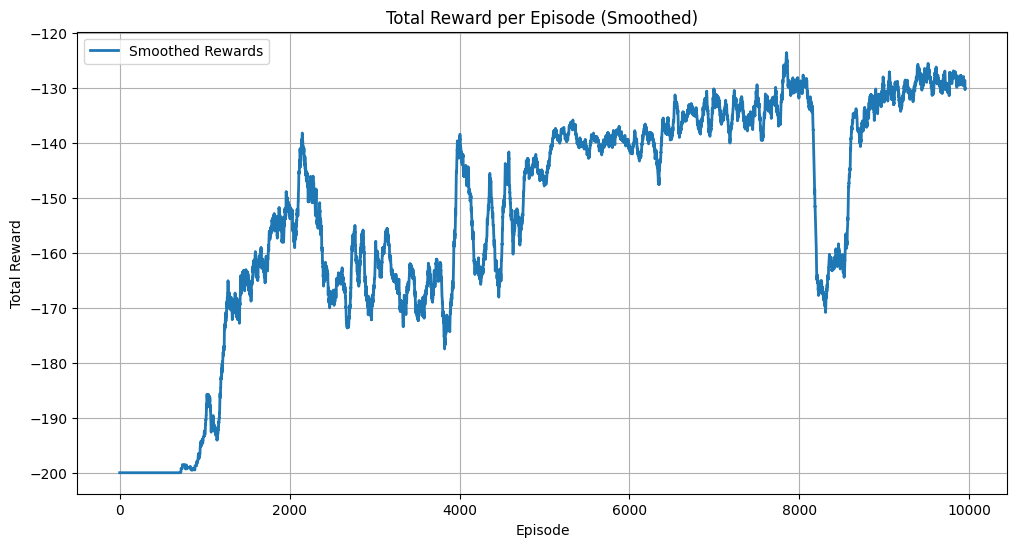

In [ ]:
# Smooth rewards using moving average
def moving_average(data, window_size):
    # Use NumPy's convolve function to calculate the moving average.
    # np.ones(window_size) creates an array of ones with length equal to window_size.
    # Dividing by window_size normalizes the array, so the sum of all elements equals 1.
    # This creates a uniform sliding window to compute averages.
    #
    # The 'valid' mode ensures the result only includes positions where the entire window
    # fits within the bounds of the input data, reducing the output size.
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

smoothed_rewards_qlearning = moving_average(rewards, window_size=50)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(smoothed_rewards_qlearning, label='Smoothed Rewards', linewidth=2)
plt.xlabel('Environment Steps')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode (Smoothed)')
plt.grid(True)
plt.legend()
plt.show()

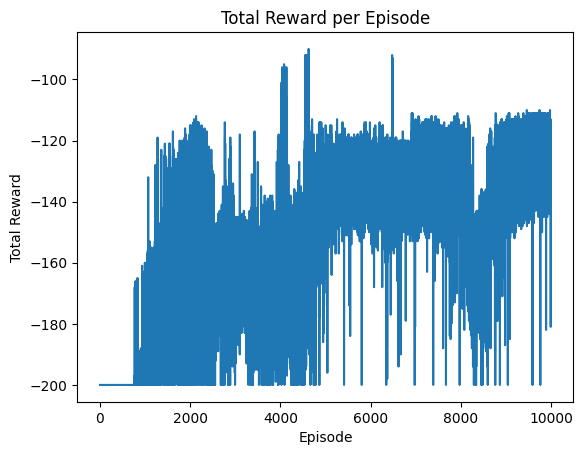

In [ ]:
# Plotting the results
plt.plot(rewards)
plt.xlabel('Environment Steps')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

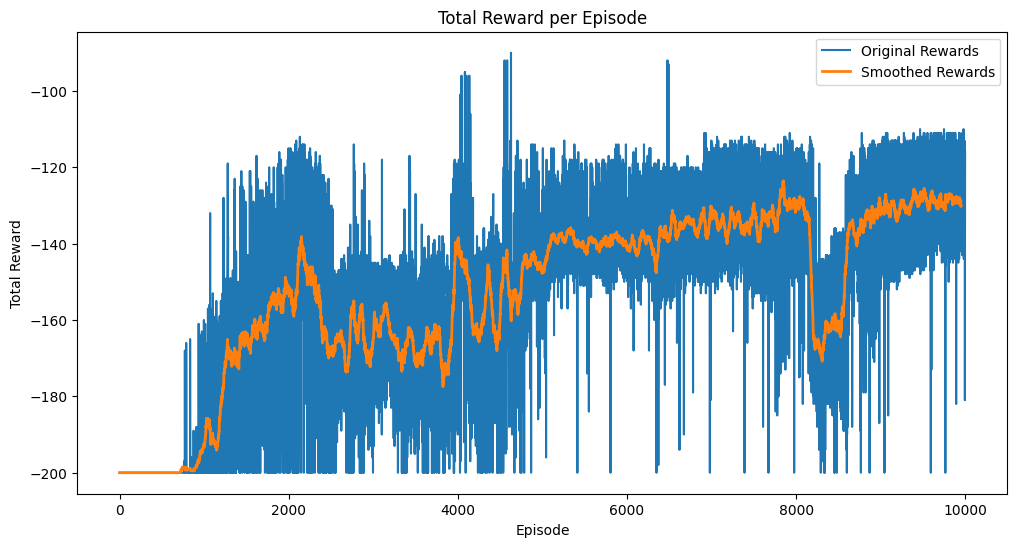

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(rewards, label='Original Rewards')
plt.plot(range(len(smoothed_rewards_qlearning)), smoothed_rewards_qlearning, label='Smoothed Rewards', linewidth=2)
plt.xlabel('Environment Steps')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.legend()
plt.show()

This plot shows the total rewards per episode in a Q-learning algorithm, comparing raw rewards (blue) and smoothed rewards (orange) to highlight the learning trend. The blue curve reflects the raw rewards, which are highly volatile due to randomness in the learning process, while the orange curve represents the moving average of the past 50 episodes, reducing noise and revealing long-term performance improvements. The smoothed rewards show a gradual improvement over episodes, indicating that the agent is learning, with initial low rewards followed by steady progress and occasional dips. This visualization helps assess the agent’s learning stability and progress over time, this is why we create it at the begging to comprehensively compare the agent learning rate.

### Part 2: Train a Deep Q-network (DQN) Agent

#### Introduction to Deep Reinforcement Learning with JAX

####  Mountain Car environment

In [47]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# create the MountainCar-v0' environment
env, env_params = gymnax.make('MountainCar-v0')
# inspect default environment settings
print("Environment parameters:", env_params)

Environment parameters: EnvParams(max_steps_in_episode=200, min_position=-1.2, max_position=0.6, max_speed=0.07, goal_position=0.5, goal_velocity=0.0, force=0.001, gravity=0.0025)


In [48]:
# Verify observation and action space
print("Action Space Size:", env.num_actions)

Action Space Size: 3


In [49]:
# observation space dimensionality
env.observation_space(env_params).shape

(2,)

In [50]:
# action space dimensionality
env.action_space(env_params).n

3

In [51]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([-0.58275205,  0.        ], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), position=Array(-0.58275205, dtype=float32), velocity=Array(0., dtype=float32, weak_type=True)))

In [52]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

c:\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array([-5.8331072e-01, -5.5867527e-04], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), position=Array(-0.5833107, dtype=float32), velocity=Array(-0.00055868, dtype=float32)),
 Array(-1., dtype=float32, weak_type=True),
 Array(False, dtype=bool))

In [53]:
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action)

c:\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [54]:
vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))

num_envs = 8
vmap_keys = jax.random.split(rng, num_envs)

obs, state = vmap_reset(vmap_keys, env_params)
n_obs, n_state, reward, done, _ = vmap_step(vmap_keys, state, jax.numpy.zeros(num_envs), env_params)
print(n_obs.shape)

(8, 2)


In [55]:
jax.devices()

[CpuDevice(id=0)]

In [56]:
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x204852a0650>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 131072,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'target_update_freq': 1,
 'polyak': 0.99,
 'normalize_observations': False,
 'num_envs': 1,
 'buffer_size': 131072,
 'fill_buffer': 2048,
 'batch_size': 256,
 'actor': {'action_dim': 3,
  'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x20484e952e0>,
  'parent': None,
  'name': None},
 'critic': {'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x20484efd700>,
  '

#### Setting up the training configuration

In [57]:
CONFIGS = { 
    'eval_freq': 5000, # Default da professora
    'skip_initial_evaluation': False, #adicionamos
    'total_timesteps': 100000, # mudamos
    'learning_rate': 0.0003, # Default da professora
    'gamma': 0.9, # mudamos
    'max_grad_norm': 10.0, #adicionamos
    'normalize_observations': False, #adicionamos
    'target_update_freq': 200, # Default da professora
    'polyak': 0.98, # Default da professora
    'num_envs': 1, # Default da professora
    'buffer_size': 100000, # Default da professora
    'fill_buffer': 1000, # Default da professora
    'batch_size': 100, # Default da professora
    'eps_start': 1.0, # Default da professora
    'eps_end': 0.01, # Default da professora
    'exploration_fraction': 0.5, # Default da professora
    'num_epochs': 10, # mudamos
    'ddqn': True, # Default da professora
    'agent': {'hidden_layer_sizes': (64, 64), 'activation': 'swish', 'action_dim': 3, 'parent': None, 'name': None}, # mudamos
    }

#### Let's create the algorithm instance for DQN in the MountainCar-v0 environment:

In [65]:
algo_str = "dqn"
env_str = "MountainCar-v0"

algo_cls = get_algo(algo_str)
algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
algo = algo.replace(total_timesteps=100000) # We tested for 10000, 50000 and 100000 and 100000 foi o mais expressivo
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x2048501bd70>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 100000,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'normalize_observations': False,
 'target_update_freq': 1,
 'polyak': 0.99,
 'num_envs': 1,
 'buffer_size': 131072,
 'fill_buffer': 2048,
 'batch_size': 256,
 'eps_start': 1.0,
 'eps_end': 0.05,
 'exploration_fraction': 0.1,
 'agent': {'hidden_layer_sizes': (64, 64),
  'activation': <PjitFunction>,
  'action_dim': 3,
  'parent': None,
  'name': None},
 'num_epochs': 1,
 'ddqn': True}

#### Training the DQN Agent

In [66]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation_dqn = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


c:\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
c:\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 5.39684 seconds (18529.4 steps/second).


In [67]:
evaluation_dqn

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [143, 146, 149, ..., 104,  98, 156],
        [ 90, 152, 156, ..., 109,  88, 166],
        [143, 117, 118, ..., 140, 143,  90]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-143., -146., -149., ..., -104.,  -98., -156.],
        [ -90., -152., -156., ..., -109.,  -88., -166.],
        [-143., -117., -118., ..., -140., -143.,  -90.]],      dtype=float32, weak_type=True))

#### Visualization

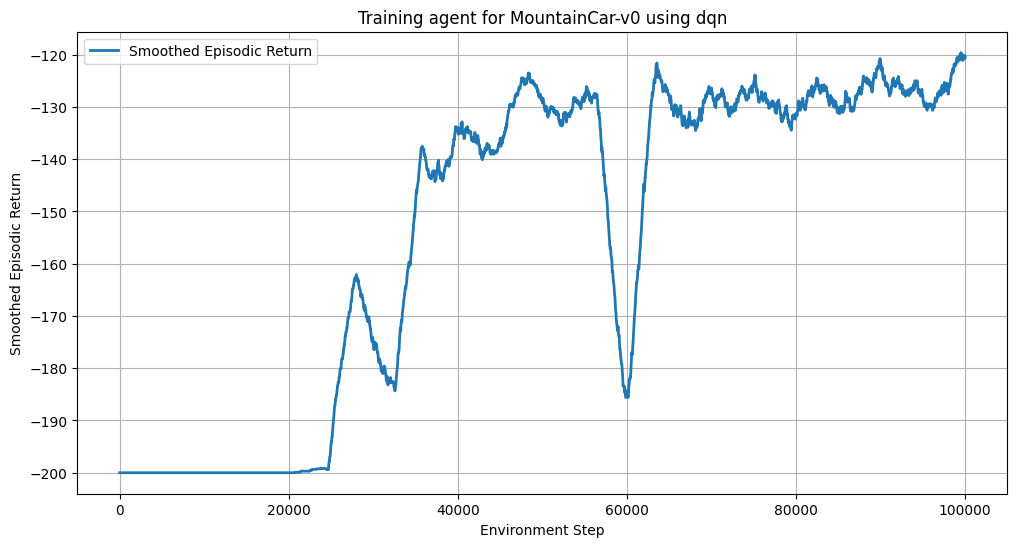

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# Define the moving average function
def simple_moving_average(data, window):
    # Use NumPy's convolve function to calculate the sum of elements within the sliding window.
    # np.ones(window) creates a sliding window of equal weights (all ones).
    # The 'valid' mode ensures that only positions where the window fully overlaps with the data
    # are included in the result, reducing the output size.
    # Dividing the convolved result by the window size normalizes the values to calculate the average.
    return np.convolve(data, np.ones(window), 'valid') / window

episode_lengths, episode_returns = evaluation_dqn
episode_returns_final_dqn = np.concatenate(episode_returns)
window_size = 100  
smoothed_mean_return_dqn = moving_average(episode_returns_final_dqn, window_size)
smoothed_x_dqn = np.linspace(0, algo.total_timesteps, len(smoothed_mean_return_dqn))

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(smoothed_x_dqn, smoothed_mean_return_dqn, label='Smoothed Episodic Return', linewidth=2)
plt.xlabel("Environment Step")
plt.ylabel("Smoothed Episodic Return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.grid(True)
plt.legend()
plt.show()

### Part 3: Train a Soft Actor-Critic (SAC) Agent

#### Setting up the training configuration

In [80]:
CONFIGS = {
    'env': 'MountainCar-v0', #envirment
    'eval_freq': 10, # mudamos
    'total_timesteps': 100000, # mudamos
    'learning_rate': 0.0003, # Default da professora
    'max_grad_norm': 10.0, # adicionamos
    'target_update_freq': 200, # Default da professora
    'polyak': 0.005, # mudamos
    'num_envs': 1, # Default da professora
    'buffer_size': 100000, # Default da professora
    'fill_buffer': 1000, # Default da professora
    'batch_size': 100, # Default da professora
    'eps_start': 1.0, # Default da professora
    'eps_end': 0.01, # Default da professora
    'exploration_fraction': 0.5, # Default da professora
    'num_epochs': 10, # mudamos
    'agent': 'SAC', # mudamos
    'agent_kwargs': { 'activation': 'relu', 'target_entropy_ratio': 0.98, 'num_critics': 2, 'actor_lr': 0.0003, 'critic_lr': 0.0003, 'alpha_lr': 0.0003, 'initial_alpha': 0.2, 'target_entropy': None, # mudamos
    }
}


#### Let's create the algorithm instance for SAC in the MountainCar-v0 environment:

In [81]:
algo_str = "sac" 
env_str = "MountainCar-v0"  

algo_cls = get_algo(algo_str)

algo = algo_cls.create(env=env_str, **CONFIGS.get(algo_str, {}))
algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x20495b96240>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 131072,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'target_update_freq': 1,
 'polyak': 0.99,
 'normalize_observations': False,
 'num_envs': 1,
 'buffer_size': 131072,
 'fill_buffer': 2048,
 'batch_size': 256,
 'actor': {'action_dim': 3,
  'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x20495b967b0>,
  'parent': None,
  'name': None},
 'critic': {'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x20495b97170>,
  '

#### Adjusting the Target Entropy Ratio

In [87]:
algo = algo.replace(target_entropy_ratio=0.55) # testamos valores entre 0.2 e 0.8 e 0.55 foi o melhor
algo = algo.replace(total_timesteps=130000) # testamos valores entre 50000 e 200000 e 130000 foi o mais expressivo

algo.config

{'env': <gymnax.environments.classic_control.mountain_car.MountainCar at 0x2048520c140>,
 'env_params': {'max_steps_in_episode': 200,
  'min_position': -1.2,
  'max_position': 0.6,
  'max_speed': 0.07,
  'goal_position': 0.5,
  'goal_velocity': 0.0,
  'force': 0.001,
  'gravity': 0.0025},
 'eval_callback': <function RLinJAX.algos.algorithm.Algorithm.create.<locals>.eval_callback(algo, ts, rng)>,
 'eval_freq': 4096,
 'skip_initial_evaluation': False,
 'total_timesteps': 130000,
 'learning_rate': 0.0003,
 'gamma': 0.99,
 'max_grad_norm': inf,
 'target_update_freq': 1,
 'polyak': 0.99,
 'normalize_observations': False,
 'num_envs': 1,
 'buffer_size': 131072,
 'fill_buffer': 2048,
 'batch_size': 256,
 'actor': {'action_dim': 3,
  'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x204854ee480>,
  'parent': None,
  'name': None},
 'critic': {'hidden_layer_sizes': (64, 64),
  'activation': <jax._src.custom_derivatives.custom_jvp at 0x2048516c950>,
  '

#### Training the SAC Agent

In [88]:
# set training seed and jit train function
rng = jax.random.PRNGKey(0)
train_fn = jax.jit(algo.train)

print("Starting to train")
# Train
start = time.time()
train_state, evaluation_sac = train_fn(rng)
time_elapsed = time.time() - start

sps = algo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train


c:\Python312\Lib\site-packages\jax\_src\numpy\array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Finished training in 7.44141 seconds (17469.8 steps/second).


In [89]:
evaluation_sac

(Array([[200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        [200, 200, 200, ..., 200, 200, 200],
        ...,
        [148, 158, 153, ..., 155, 153, 148],
        [163, 200, 149, ..., 166, 109, 158],
        [150, 152, 160, ...,  87, 152, 184]], dtype=int32, weak_type=True),
 Array([[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-148., -158., -153., ..., -155., -153., -148.],
        [-163., -200., -149., ..., -166., -109., -158.],
        [-150., -152., -160., ...,  -87., -152., -184.]],      dtype=float32, weak_type=True))

#### Visualization

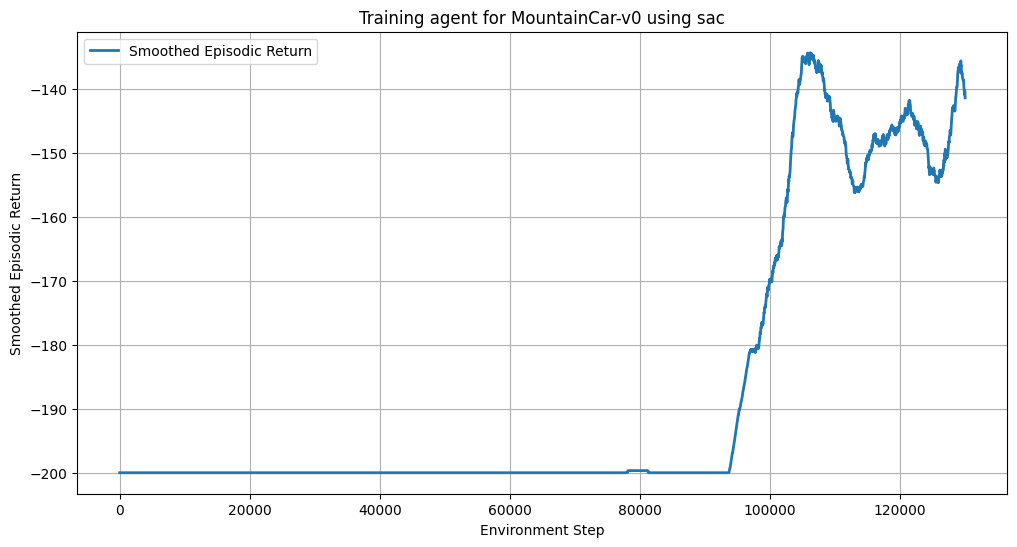

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the moving average function
def simple_moving_average(data, window):
    # Use NumPy's convolve function to calculate the sum of elements within the sliding window.
    # np.ones(window) creates a sliding window of equal weights (all ones).
    # The 'valid' mode ensures that only positions where the window fully overlaps with the data
    # are included in the result, reducing the output size.
    # Dividing the convolved result by the window size normalizes the values to calculate the average.
    return np.convolve(data, np.ones(window), 'valid') / window

episode_lengths, episode_returns = evaluation_sac
episode_returns_final_sac = np.concatenate(episode_returns)
smoothed_mean_return_sac = moving_average(episode_returns_final_sac, window_size)
smoothed_x_sac = np.linspace(0, algo.total_timesteps, len(smoothed_mean_return_sac))

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(smoothed_x_sac, smoothed_mean_return_sac, label='Smoothed Episodic Return', linewidth=2)
plt.xlabel("Environment Step")
plt.ylabel("Smoothed Episodic Return")
plt.title(f"Training agent for {env_str} using {algo_str}")
plt.grid(True)
plt.legend()
plt.show()

### Compare the Agents

Q-Learning demonstrates a significantly slower and noisier learning process compared to SAC and DQN. Its performance gains are gradual, reflecting inefficiency in handling complex environments. This is likely due to its tabular nature, which lacks the function approximation capabilities of the other two algorithms.

In contrast, SAC and DQN both exhibit sharp and steady performance improvements, with faster learning and better stability. However, DQN achieves higher reward values within a shorter runtime, making it more computationally efficient than SAC despite its slightly lower stability.

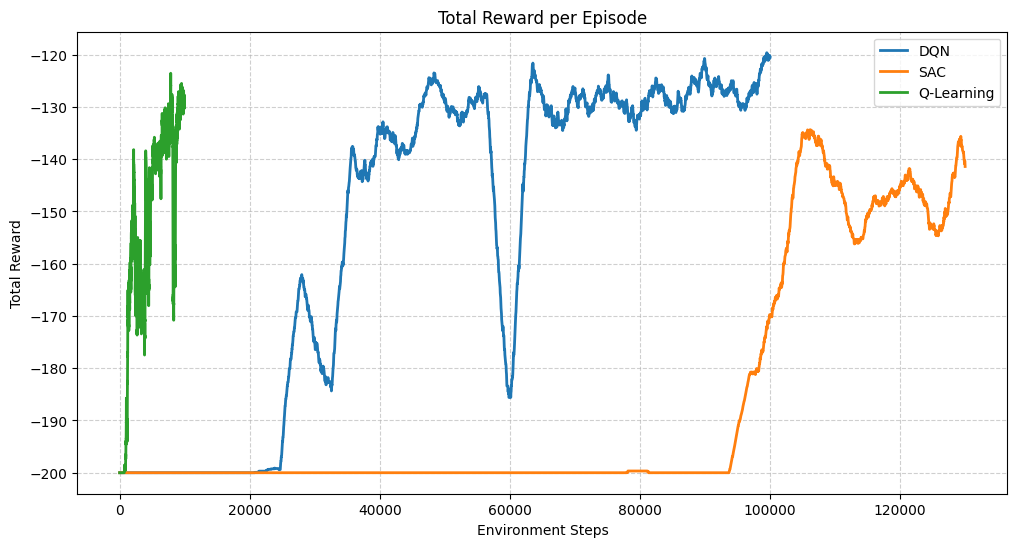

In [93]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(smoothed_x_dqn, smoothed_mean_return_dqn, label='DQN', linewidth=2)
plt.plot(smoothed_x_sac, smoothed_mean_return_sac, label='SAC', linewidth=2)
plt.plot(range(len(smoothed_rewards_qlearning)), smoothed_rewards_qlearning, label='Q-Learning', linewidth=2)
plt.xlabel('Environment Steps')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)  # Horizontal and vertical grid lines with dashed style
plt.legend()
plt.show()